In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

#http://fnl.es/a-quick-reference-for-working-with-tensorflow.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pyvirtualdisplay import Display

import tensorflow.compat.v1 as tf
from collections import deque
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input , BatchNormalization, Concatenate, LayerNormalization, LSTM,Reshape
from tensorflow.keras.optimizers import Adam
import random
import tqdm
import pandas as pd

tf.disable_eager_execution()
import math
import time


D:\Users\Near\anaconda3\envs\tf21\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\Near\anaconda3\envs\tf21\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\Near\anaconda3\envs\tf21\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\Near\anaconda3\envs\tf21\lib\site-packages\tensor

In [3]:
tf.reset_default_graph()
epsilon = 0

#https://stackoverflow.com/questions/49432852/estimating-high-resolution-images-from-lower-ones-using-a-keras-model-based-on-c
#https://stackoverflow.com/questions/49603498/convolution2d-lstm-versus-convlstm2d
#https://stackoverflow.com/questions/49146881/passing-cnn-outputs-to-lstm-in-tensorflow



In [4]:
class Agent:
    def __init__(self, name, state_shape, n_actions, sess, isConvLSTM, reuse=False):
        with tf.variable_scope(name, reuse=reuse):

            inputs = Input(shape=state_shape)
            x = Dense(32, activation='relu', name ="inp1")(inputs)
            x = Dense(3642, activation='relu', name ="inp2")(x)
            if (isConvLSTM == False):
                x = Dense(32, activation='relu', name ="inp3")(x)

            if (isConvLSTM == True):
                rnn_in = Reshape((1 ,x.shape[1]), input_shape=x.shape)(x)
                x = LSTM(64, return_sequences=False, name ="lstm_enc_1")(rnn_in)

            # two different output layers
            logits = Dense(n_actions, activation='linear', name ="logits")(x)
            state_value = Dense(1, activation='linear', name ="v")(x)
            self.network = Model(inputs=inputs, outputs=[logits, state_value])

            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)

    def symbolic_step(self, state_t):
        logits,s = self.network(state_t)
        return logits, s[:,0]

    def step(self, state_t):
        return sess.run(self.agent_outputs, {self.state_t: state_t})

    def sample_actions(self, agent_outputs,epsilon):
        if np.random.random() < epsilon:
            return np.random.randint(n_actions, size=nEnviroment)

        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])


In [5]:
class LunarLanderA3C:
    def __init__(self, sess,env, lstm,gae):
        # These placeholders mean exactly the same as in "Let's try it out" section above
        self.sess =sess

        self.filepath = "D:\\Artificial_Intelligence\\RL\\LunarLander\\data.txt"
        self.batch_size =10
        self.memory = deque(maxlen= self.batch_size)
        self.nEnviroment=10
        self.Training= 2000000#400000
        self.learning_rate= 0.0001#0.001
        self.entropy_factor = 0.001#0.0001  

        self.rewards_history = []
        self.entropy_history = []
        self.actor_history =[]
        self.critic_history =[]
        self.advantage_history = []
        self.target_history =[]
        self.v_history =[]
        self.actionList =[]

        self.reward_step =0

        self.writer = tf.summary.FileWriter('.\\graphs', sess.graph)

        self.is_gae = gae
        self.isConvLSTM = lstm 
        self.env = env
        self.obs_shape = self.env.observation_space.shape
        self.n_actions = self.env.action_space.n

        print("Observation shape:", self.obs_shape)
        print("Num actions:", self.n_actions)

        self.agent = Agent("agent", self.env.observation_space.shape, self.env.action_space.n, self.sess,self.isConvLSTM)
        self.states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))    
        self.next_states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))
        self.actions_ph = tf.placeholder('int32', (None,))
        self.rewards_ph = tf.placeholder('float32', (None,))
        self.is_done_ph = tf.placeholder('float32', (None,))
        self.game_reward = tf.placeholder('float32', [None,])

        self.logits, self.state_values = self.agent.symbolic_step(self.states_ph)
        self.next_logits, self.next_state_values = self.agent.symbolic_step(self.next_states_ph)

        self.next_state_values = self.next_state_values * (1 - self.is_done_ph)

        self.probs = tf.nn.softmax(self.logits, axis=-1)            # [n_envs, n_actions]
        self.logprobs = tf.nn.log_softmax(self.logits, axis=-1)     # [n_envs, n_actions]

        self.logp_actions = tf.reduce_sum(self.logprobs * tf.one_hot(self.actions_ph, self.n_actions), axis=-1) # [n_envs,]

        self.gamma = 0.99
        self.advantage = self.rewards_ph + self.gamma*self.next_state_values - self.state_values
        self.entropy = -tf.reduce_sum(self.probs * self.logprobs, 1, name="entropy")
        self.target_state_values = self.rewards_ph+self.gamma*self.next_state_values
        self.actor_loss = -tf.reduce_mean(self.logp_actions * tf.stop_gradient(self.advantage), axis=0) - self.entropy_factor * tf.reduce_mean(self.entropy, axis=0)
        self.critic_loss = tf.reduce_mean((self.state_values - tf.stop_gradient(self.target_state_values))**2, axis=0)
        self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.actor_loss + self.critic_loss)


    def evaluate(self, n_games=1):
        """Plays an a game from start till done, returns per-game rewards """
        for _ in range(n_games):
            state = self.env.reset()

            total_reward = 0
            total_reward_list = []
            while True:
                action = self.agent.sample_actions(self.agent.step([state]),0)[0]
                state, reward, done, info = self.env.step(action)
                total_reward += reward
                if done:
                    break
            total_reward_list.append(total_reward)
        self.rewards_history.append(np.mean(total_reward_list))

        self.reward_step +=1

        return self.rewards_history


    def train(self,batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,step):

        feed_dict = {
                self.states_ph: batch_states,
                self.actions_ph: batch_actions,
                self.next_states_ph: batch_next_states,
                self.rewards_ph: batch_rewards,
                self.is_done_ph: batch_done,
            }

        _, ent_t,act,crit,adv,targ,v,sum_adv,sum_ent,sum_target,sum_act_loss,sum_crit_loss,sum_batchreward,sum_v = sess.run([self.train_step, self.entropy,self.actor_loss ,self.critic_loss,self.advantage,
                                                 self.target_state_values,self.state_values,
                                                 self.summary_adv,self.summary_ent,self.summary_target,self.summary_act_loss,self.summary_crit_loss,
                                                 self.summary_batchreward,self.summary_v], feed_dict)

        self.entropy_history.append(np.mean(ent_t))
        self.actor_history.append(np.mean(act))
        self.critic_history.append(np.mean(crit))
        self.advantage_history.append(np.mean(adv))
        self.target_history.append(np.mean(targ))
        self.v_history.append(np.mean(v))
        for a in batch_actions:
            self.actionList.append(a)


    def ewma(self,x, span=100):
        return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

    def plots(self):
        ipythondisplay.clear_output(wait=True)
        plt.figure(figsize=[35,13])
        plt.subplot(2,4,1)
        plt.plot(self.rewards_history, label='reward')
        plt.plot(self.ewma(np.array(self.rewards_history), span=10), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()

        plt.subplot(2,4,2)
        plt.plot(self.actor_history, label='Actor Loss')
        plt.plot(self.ewma(np.array(self.actor_history), span=10), marker='.', label='Actor Loss ewma@10')
        plt.title("Policy Function"); plt.grid(); plt.legend()  

        plt.subplot(2,4,3)
        plt.plot(self.entropy_history, label='Entropy')
        plt.plot(self.ewma(np.array(self.entropy_history), span=10), marker='.', label='Entropy ewma@10')
        plt.title("Policy Function"); plt.grid(); plt.legend()      

        plt.subplot(2,4,4)
        plt.plot(self.target_history, label='Target ')
        plt.plot(self.v_history, label='V')
        plt.title("Target/V"); plt.grid(); plt.legend()

        plt.subplot(2,4,5)
        plt.plot(self.advantage_history, label='Advantage')
        plt.title("Advantage"); plt.grid(); plt.legend()  

        plt.subplot(2,4,6)
        plt.plot(self.critic_history, label='Critic Loss')
        plt.plot(self.ewma(np.array(self.critic_history), span=10), marker='.', label='Critic Loss ewma@10')
        plt.title("Value function"); plt.grid(); plt.legend()   

        plt.subplot(2,4,7)
        plt.plot(self.actionList, label='Actions')
        plt.title("Actions"); plt.grid(); plt.legend()  

        plt.show()



In [6]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        self.envs = [gym.make("LunarLander-v2").env for _ in range(n_envs)]
        self.counter = [0 for _ in range(n_envs)]
    
    def reset(self):
        return np.array([env.reset() for env in self.envs])
  
    def step(self, actions):
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        self.counter = [(self.counter[j]+1) for j in range(len(self.envs))]

        for i in range(len(self.envs)):
            if done[i] or self.counter[i] == 4000:
                new_obs[i] = self.envs[i].reset()
                self.counter[i] =0

        return new_obs, rewards, done, infos


In [7]:
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(graph= tf.get_default_graph(), config =config)
RESET = 1
is_gae = False
isConvLSTM = True 


In [8]:
#display = Display(visible=0, size=(400, 300))
#display.start()
env = gym.make("LunarLander-v2")
lunarlanderA3C = LunarLanderA3C(sess,env, isConvLSTM,is_gae)

Observation shape: (8,)
Num actions: 4
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
if (RESET == 1):
  # ************ RESET everything **************************
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    f=open(lunarlanderA3C.filepath, "w")
    f.write("")
    f.close()
else:
  # ************ LOAD everything **************************
    epsilon = 0.01 
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('D:\\Artificial_Intelligence\\RL\\LunarLander\\'))
    f=open(lunarlanderA3C.filepath,'r')
    for line in f:
        lunarlanderA3C.rewards_history.append(float(line.split()[0]))
        lunarlanderA3C.actor_history.append(float(line.split()[1]))
        lunarlanderA3C.entropy_history.append(float(line.split()[2]))
        lunarlanderA3C.target_history.append(float(line.split()[3]))
        lunarlanderA3C.v_history.append(float(line.split()[4]))
        lunarlanderA3C.advantage_history.append(float(line.split()[5]))
        lunarlanderA3C.critic_history.append(float(line.split()[6]))
    f.close()
    lunarlanderA3C.plots()

# Validate
rewards = lunarlanderA3C.evaluate(n_games=3)

env_batch = EnvBatch(10)
batch_states = env_batch.reset()
batch_actions = lunarlanderA3C.agent.sample_actions(lunarlanderA3C.agent.step(batch_states),0)
batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

#Initialize
env_batch = EnvBatch(10)
batch_states = env_batch.reset()
epsilon=0


State shape: (10, 8)
Actions: [2 3 3 1 3 2 1 1 3 0]
Rewards: [ 2.27620879 -1.42083373 -0.94874505 -2.17511884  2.40632518  0.16958321
 -0.61798333 -1.36851947  0.23712738 -0.93697362]
Done: [False False False False False False False False False False]


D:\Users\Near\anaconda3\envs\tf21\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 25%|█████████████████████████████████████████████▊                                                                                                                                            | 491997/2000000 [3:59:57<5:16:28, 79.42it/s]

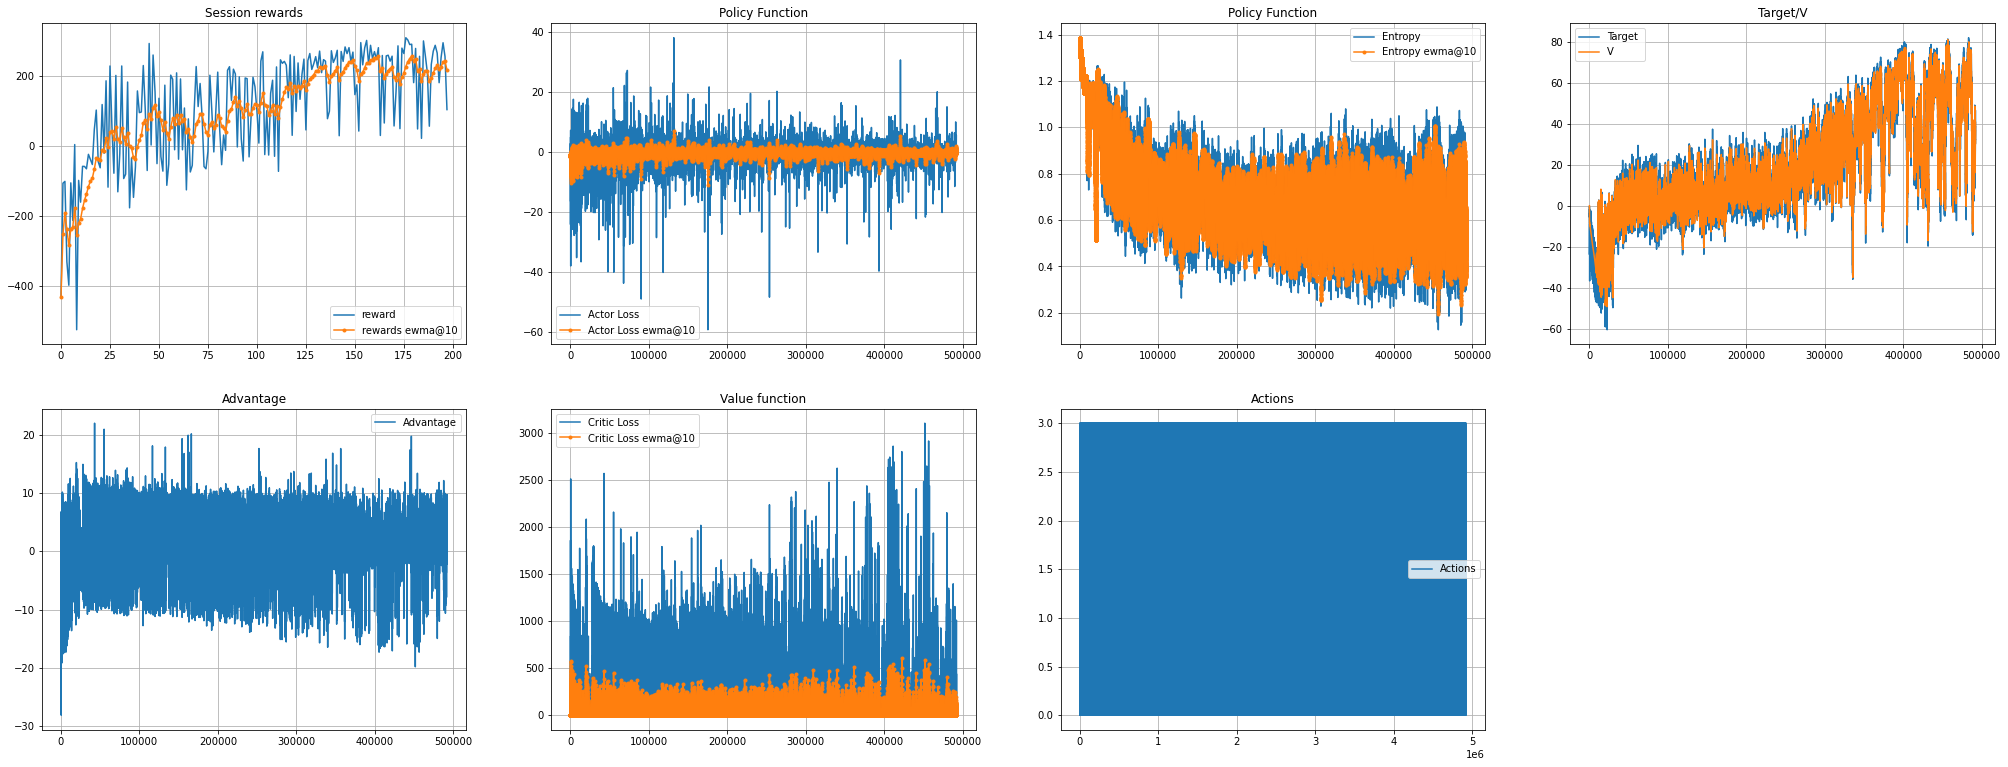

 25%|█████████████████████████████████████████████▌                                                                                                                                           | 492500/2000000 [4:00:06<12:14:56, 34.19it/s]

Your agent reached the objetive


In [10]:

f=open(lunarlanderA3C.filepath, "a")
with tqdm.trange(len(lunarlanderA3C.entropy_history), lunarlanderA3C.Training) as t:
    for i in t:
        agent_outputs = lunarlanderA3C.agent.step(batch_states)
        batch_actions = lunarlanderA3C.agent.sample_actions(agent_outputs,epsilon)
        batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
        # Reward scaling. See above for explanation.
        lunarlanderA3C.train(batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,i)
        batch_states = batch_next_states

        if i % 500 == 0:

            if i % 2500 == 0:

                lunarlanderA3C.evaluate(n_games=3)
                saver.save(sess, "D:\\Artificial_Intelligence\\RL\\LunarLander\\model.h5")

            if len(lunarlanderA3C.rewards_history)> 100 :
                if np.mean(lunarlanderA3C.rewards_history[-100:]) >= 200:
                    print("Your agent reached the objetive")
                    break

            if epsilon > 0.01 :
                epsilon = epsilon*0.99

            lunarlanderA3C.plots()
            if i %10000 ==0:
                f.close()
                f=open(lunarlanderA3C.filepath, "a+")

            f.write("%f %f %f %f %f %f %f\n" % (lunarlanderA3C.rewards_history[-1],lunarlanderA3C.actor_history[-1], lunarlanderA3C.entropy_history[-1],lunarlanderA3C.target_history[-1],lunarlanderA3C.v_history[-1],lunarlanderA3C.advantage_history[-1],lunarlanderA3C.critic_history[-1]))

f.close()

In [11]:
#display = Display(visible=0, size=(400, 300))
#display.start()

def evaluate2(agent, env, n_games=1):
    game_rewards = []
    for _ in range(n_games):
        state = env.reset()

        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]),0)[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

    env_monitor = gym.wrappers.Monitor(env, directory="D:\\Artificial_Intelligence\\RL\\LunarLander\\videos", force=True)
    final_rewards = evaluate2(lunarlanderA3C.agent, env_monitor, n_games=100)
    env_monitor.close()

    print("Final mean reward:", np.mean(final_rewards))

In [13]:

agent_test=lunarlanderA3C.agent
for _ in range(10):
    t_rewards=0
    state = env.reset()
    while True:
        action = agent_test.sample_actions(agent_test.step([state]),0)[0]
        state, reward, done, info = env.step(action)
        env.render()
        t_rewards += reward
        if done:
            break
    print(t_rewards)
        


258.35193411523994
282.10831000312817
262.53347850750043
247.96045237047485
260.38137493839133
295.53433699268476
223.84342740405623
288.50706716346514
270.32772383017436
272.3195578541071
